In [21]:
import os
import cv2
import json
import glob
import torch
import torchvision
import numpy as np
import tensorflow as tf
from facenet_pytorch import MTCNN
from PIL import Image
from matplotlib import pyplot as plt

In [22]:
#train_dir = 'F:\\deepfake-detection-challenge\\train_sample_videos'
train_dir = 'G:\\dfdc_train_part_10'
test_dir = 'F:\\deepfake-detection-challenge\\train_sample_videos'
test_dir_fake_faces = 'F:\\deepfake-detection-challenge\\train_sample_videos\\1_FAKE_faces'
test_dir_real_faces = 'F:\\deepfake-detection-challenge\\train_sample_videos\\0_REAL_faces'
metadata_file = 'metadata.json'
fake_image_folder = '1_FAKE_faces'
real_image_folder = '0_REAL_faces'
test_image_folder = 'test_faces'
frames_per_video = 10

In [23]:
def get_video_labels(data_dir, metadata_file):
    with open(os.path.join(data_dir, metadata_file)) as f:
        metadata = json.load(f)
        labels = {}
        for key in metadata:
             # Get the label for the video, 0 for 'FAKE' and 1 for 'REAL'
            if metadata[key]['label'] == 'FAKE':
                labels[key] = 1
            elif metadata[key]['label'] == 'REAL':
                labels[key] = 0
    return labels

In [24]:
tvl = get_video_labels(train_dir, metadata_file)

In [25]:
print(len(tvl))
total = 0
for key in tvl: 
    if tvl[key]==1: 
        total+=1
print(total)

3192
2813


In [26]:
def extract_jpg_frames_from_train_videos(video_folder, metadata_file, fake_image_folder, real_image_folder, frames_per_video):
    # Create face detector
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    mtcnn = MTCNN(margin=40, keep_all=True, post_process=False, device=device)
    
    dict_video_labels = get_video_labels(video_folder, metadata_file)
    for video in glob.glob(video_folder+"*/*.mp4"):
        video_name = os.path.basename(video)
        id = os.path.splitext(video_name)[0]
            
        v_cap = cv2.VideoCapture(video)
        v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))
        steps = v_len//frames_per_video
        if steps == 0:
            steps = 1
        for i in range(v_len):

            # Load frame
            success = v_cap.grab()
            if i % steps == 0:
                success, frame = v_cap.retrieve()
            else:
                continue
            if not success:
                continue

            # Add to batch
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = Image.fromarray(frame)
            if video_name not in dict_video_labels:
              continue
            if dict_video_labels[video_name] == 1: 
                fake_face_path = os.path.join(video_folder, fake_image_folder, "{}_{}.jpg".format(id, i))
                mtcnn(frame, save_path=fake_face_path)
            elif dict_video_labels[video_name] == 0:
                real_face_path = os.path.join(video_folder, real_image_folder, "{}_{}.jpg".format(id, i))
                mtcnn(frame, save_path=real_face_path)

In [27]:
def extract_jpg_frames_from_test_videos(video_folder, test_image_folder, frames_per_video):
    # Create face detector
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    mtcnn = MTCNN(margin=40, keep_all=True, post_process=False, device=device)
    for video in glob.glob(video_folder+"*/*.mp4"):
        video_name = os.path.basename(video)
        id = os.path.splitext(video_name)[0]
            
        v_cap = cv2.VideoCapture(video)
        v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))
        steps = v_len//frames_per_video
        if steps == 0:
            steps = 1
        for i in range(v_len):

            # Load frame
            success = v_cap.grab()
            if i % steps == 0:
                success, frame = v_cap.retrieve()
            else:
                continue
            if not success:
                continue

            # Add to batch
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = Image.fromarray(frame)
            test_face_path = os.path.join(video_folder, test_image_folder, "{}_{}.jpg".format(id, i))
            mtcnn(frame, save_path=test_face_path)

In [28]:
#extract_jpg_frames_from_train_videos(train_dir, metadata_file,fake_image_folder, real_image_folder, frames_per_video)
#extract_jpg_frames_from_test_videos(test_dir, test_image_folder, frames_per_video)

In [29]:
batch_size = 32
img_height = 160
img_width = 160

In [30]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  labels='inferred',
  label_mode='int',
  color_mode='rgb',
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size, 
  shuffle=True)

Found 47643 files belonging to 2 classes.
Using 33351 files for training.


In [31]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  labels='inferred',
  label_mode='int',
  color_mode='rgb',
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 47643 files belonging to 2 classes.
Using 14292 files for validation.


In [32]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  labels='inferred',
  label_mode='int',
  color_mode='rgb',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4747 files belonging to 2 classes.


In [33]:
class_names = train_ds.class_names
print(class_names)

['0_REAL_faces', '1_FAKE_faces']


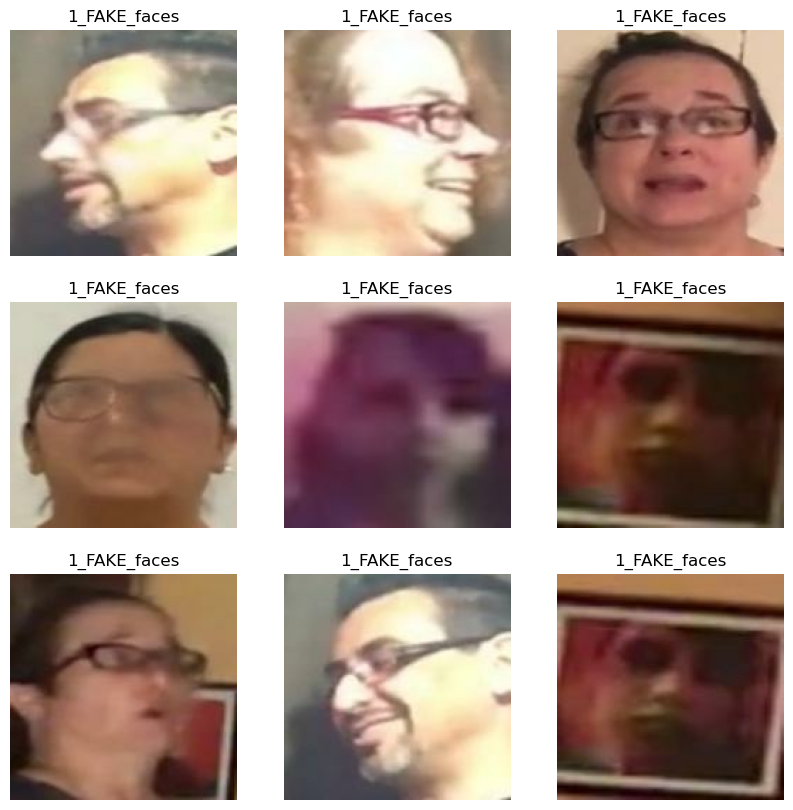

In [65]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [35]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [36]:
print(type(train_ds))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [46]:
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [47]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.BinaryCrossentropy(),
  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [48]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=4
)

Epoch 1/4
1043/1043 [==============================] - 734s 703ms/step - loss: 0.2812 - accuracy: 0.9064 - precision_3: 0.9070 - recall_3: 0.9990 - val_loss: 0.2645 - val_accuracy: 0.9086 - val_precision_3: 0.9145 - val_recall_3: 0.9914
Epoch 2/4
1043/1043 [==============================] - 691s 662ms/step - loss: 0.2541 - accuracy: 0.9122 - precision_3: 0.9151 - recall_3: 0.9954 - val_loss: 0.2456 - val_accuracy: 0.9132 - val_precision_3: 0.9200 - val_recall_3: 0.9899
Epoch 3/4
1043/1043 [==============================] - 711s 682ms/step - loss: 0.2258 - accuracy: 0.9199 - precision_3: 0.9263 - recall_3: 0.9903 - val_loss: 0.2278 - val_accuracy: 0.9197 - val_precision_3: 0.9409 - val_recall_3: 0.9721
Epoch 4/4
1043/1043 [==============================] - 719s 689ms/step - loss: 0.1972 - accuracy: 0.9301 - precision_3: 0.9375 - recall_3: 0.9887 - val_loss: 0.2056 - val_accuracy: 0.9274 - val_precision_3: 0.9489 - val_recall_3: 0.9718


In [50]:
#model.save('F:\\deepfake-detection-challenge\\ks3232321281model_epoch2')
#model.save('F:\\deepfake-detection-challenge\\ks3232321281model_epoch3')
#model.save('F:\\deepfake-detection-challenge\\ks3232321281model_epoch5')
#model.save('F:\\deepfake-detection-challenge\\ks3232321281model_epoch3_dfdc_train_part_10')
#model.save('F:\\deepfake-detection-challenge\\ks3232321281model_epoch4_dfdc_train_part_10_precision_recall')
#model.save('F:\\deepfake-detection-challenge\\ks3232321281model_epoch3_dfdc_train_part_10_precision_recall')
#model.save('F:\\deepfake-detection-challenge\\ks3232321281model_epoch2_dfdc_train_part_10_precision_recall')
#model.save('F:\\deepfake-detection-challenge\\ks3232321281model_epoch1_dfdc_train_part_10_precision_recall')

In [57]:
#model = tf.keras.models.load_model('F:\\deepfake-detection-challenge\\ks3232321281model_epoch2_dfdc_train_part_10_precision_recall')

In [72]:
print(model.metrics_names)

['loss', 'accuracy', 'precision', 'recall']


In [56]:
print(model.evaluate(test_ds))

149/149 [==============================] - 24s 155ms/step - loss: 0.5534 - accuracy: 0.7632 - precision: 0.7920 - recall: 0.9462
[0.553429901599884, 0.763218879699707, 0.7920324206352234, 0.9462221264839172]


In [66]:
def predict_face_image_file(model, face_image_file):
    img_height = 160
    img_width = 160
    img = tf.keras.preprocessing.image.load_img(face_image_file, target_size=(img_height, img_width))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    predictions = model.predict(img_array)
    print(predictions)
    return predictions[0][0]

In [67]:
def predict_face_images_from_folder(model, image_folder):
    img_height = 160
    img_width = 160
    total_predictions = []
    for face_image_file in glob.glob(image_folder+"*/*.jpg"):
        img = tf.keras.preprocessing.image.load_img(face_image_file, target_size=(img_height, img_width))
        #print(type(img))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        predictions = model.predict(img_array)
        total_predictions.append(predictions[0][0])
        print(predictions)
    return total_predictions

In [68]:
def predict_video_file(model, video_file, frames_per_video):
    img_height = 160
    img_width = 160
    # Create face detector
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    mtcnn = MTCNN(margin=40, keep_all=True, post_process=False, device=device)
    face_list = []
    v_cap = cv2.VideoCapture(video_file)
    v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))
    steps = v_len//frames_per_video
    if steps == 0:
        steps = 1
    for i in range(v_len):
        # Load frame
        success = v_cap.grab()
        if i % steps == 0:
            success, frame = v_cap.retrieve()
        else:
            continue
        if not success:
            continue
        # Add to batch
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        faces = mtcnn(frame)
        if faces is not None: 
            for face in faces: 
                face_list.append(face)
            
    total_predictions = []
    for face in face_list: 
        img_array = face.numpy().reshape(img_height,img_width,3)
        img_array = np.expand_dims(img_array, axis=0)
        predictions = model.predict(img_array)
        #print(predictions[0][0])
        total_predictions.append(predictions[0][0])
    return total_predictions

In [69]:
def predict_video_files_from_folder(model, video_folder, frames_per_video, metadata_file=None):
    dict_video_pred = {}
    with open(os.path.join(video_folder, "predictions.txt"), "w") as f:
        f.write('filename,label'+'\n')
        for video_file in glob.glob(video_folder+"*/*.mp4"):
            v_pred = max(predict_video_file(model, video_file, frames_per_video))
            video_name = os.path.basename(video_file)
            if v_pred <= 0.8:
                f.write(video_name+',0'+'\n')
                dict_video_pred[video_name] = 0
            elif v_pred > 0.8: 
                f.write(video_name+',1'+'\n')
                dict_video_pred[video_name] = 1
    if metadata_file: 
        video_labels = get_video_labels(video_folder, metadata_file)
        total_videos = 0
        total_wrong_pred = 0
        for key in video_labels: 
            if key in dict_video_pred: 
                total_videos += 1
                if video_labels[key] != dict_video_pred[key]: 
                    total_wrong_pred += 1
        print("prediction accuracy rate: " + str(1-total_wrong_pred/total_videos))
                    

In [69]:
#epoch3
tmp = 0
for pred in total_predictions0: 
    if pred > 0.8: 
        tmp += 1
print(tmp/len(total_predictions0))

tmp = 0
for pred in total_predictions1: 
    if pred > 0.8: 
        tmp += 1
print(tmp/len(total_predictions1))

0.5379377431906615
0.6851304114009142


In [70]:
#epoch3
tmp = 0
for pred in total_predictions0: 
    if pred > 0.7: 
        tmp += 1
print(tmp/len(total_predictions0))

tmp = 0
for pred in total_predictions1: 
    if pred > 0.7: 
        tmp += 1
print(tmp/len(total_predictions1))

0.6245136186770428
0.7945684323742942


In [365]:
vgg = tf.keras.applications.vgg16.VGG16(include_top=False, input_shape=(160, 160, 3))
model2 = tf.keras.Sequential([tf.keras.layers.Rescaling(1./255)])
model2.add(vgg)
model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.Dense(256, activation='relu'))
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))
vgg.trainable = False

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [460]:
model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5
)

#model2.save('F:\\deepfake-detection-challenge\\vgg16model2')

In [458]:
#model2 = tf.keras.models.load_model('F:\\deepfake-detection-challenge\\vgg16model2')

In [90]:
def extract_faces(video_folder, image_folder):
    for image in glob.glob(os.path.join(video_folder, image_folder)+"*/*.jpg"):
        # Load the image
        img = cv2.imread(image)
        image_name = os.path.basename(image)

        # Load the Haar Cascade classifier for face detection
        face_cascade = cv2.CascadeClassifier(os.path.join(video_folder, 'haarcascade_frontalface_default.xml'))

        # Convert the image to grayscale
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Detect faces in the image
        faces = face_cascade.detectMultiScale(img_gray, scaleFactor=1.3, minNeighbors=5)
        
        # Extract faces from the image
        for (x, y, w, h) in faces:
            face = img[y:y+h, x:x+w]
            #face_gray = img_gray[y:y+h, x:x+w]
            cv2.imwrite(os.path.join(video_folder, image_folder, 'faces', image_name.split('.')[0] + '_' + str(x) + str(y) + '_face.jpg'), face)
